In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules



## Task
The task is split into two sub-tasks: finding optimal hub locations and finding interesting relationships between product groups.

### Part 1: Finding optimal hub locations
Guidelines for the Analysis phase:

Visualize the client locations by making a two-dimensional scatterplot. Can you give a geographic interpretation for what you see? Using k-means clustering, find optimal locations (i.e. x and y coordinates) for three drone depots. Each depot should serve its surrounding clients.
Hint: you can use Seaborn https://seaborn.pydata.org/generated/seaborn.scatterplot.html or Matplotlib: https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html.

Hint: The centroids serve as the depot locations. You will later need to change the number of depots, so design your program in such a way that you just need to modify a single value to do that.

Attach the information on the closest depot to each client. That is, generate a data frame that is similar to the original one with the exception that it has an additional column that contains the identifier of the depot nearest to the client. Print the first 10 rows of the new data frame.

Make a scatterplot that uses three different colours. The markers with the same colour are served by the same depot. Hint: Re-check the web page(s) mentioned in the first task.

Play with the number of depots. What are the optimal locations for 10 depots, for example? Do you see a difference in the computation time when the number of depots increases?

Replace k-means with agglomerative hierarchical clustering and explore it with various depot numbers. What are your observations?

In the end, your report should give a recommendation on how the depots should be placed, depending on the number of depots. You should also discuss the differences between k-means and hierarchical clustering in this context.

### Part 2: Finding interesting relationships between product groups
Use association rule mining to find interesting relationships between product groups.

Your report should include a clear recommendation on how the company should use the results of the association rule mining to increase its revenue.

## Business Understanding
### The Goal:
The goal of this task is to determine the most efficient locations for drone depots to serve clients. By analyzing the geographic distribution of client locations. The aim is to find the optimal locations for the depots to minimize the distance between the depots and the clients they serve. The task is split into two sub-tasks: finding optimal hub locations and finding interesting relationships between product groups.
First part will be achieved by using k-means clustering to find the optimal locations for three drone depots. The second part will be achieved by using association rule mining to find interesting relationships between product groups.

### Requirements & Limitations:
- **Visualize client locations**: Create a two-dimensional scatterplot of client locations.
- **K-means clustering**: Use k-means clustering to find optimal locations for three drone depots.
- **Depot assignment**: Attach the closest depot information to each client in a new data frame.
- **Scatterplot with depot assignments**: Create a scatterplot with different colors for each depot's clients.
- **Hierarchical clustering**: Replace k-means with agglomerative hierarchical clustering and explore with various depot numbers.
- **Association rule mining**: Use association rule mining to find relationships between product groups.

### Expected Outcome:
- **Scatterplot of client locations**: A visual representation of client locations.
- **Optimal depot locations**: Coordinates of the optimal depot locations using k-means clustering.
- **Hierarchical clustering analysis**: Observations and comparisons of depot placements using hierarchical clustering.
- **Recommendations**: A report with recommendations on depot placements and a discussion on clustering methods.

## Data Understanding
### Dataset drone_prod_groups.csv
This dataset contains information about various product groups. Each row represents a unique product group with multiple products listed under it.
- **Columns**:
ID: Identifier for the product group.
Prod1 to Prod20: Products associated with the product group.

### Dataset drone_cust_locations.csv
This dataset contains the geographic locations of clients. Each row represents a client with their respective coordinates.
- **Columns**:
clientid: Unique identifier for the client.
x: X-coordinate of the client's location.
y: Y-coordinate of the client's location.

In [310]:
locations_df = pd.read_csv('../datasets/drone_cust_locations.csv', delimiter=';')
groups_df = pd.read_csv('../datasets/drone_prod_groups.csv')

# Describe the data
print(locations_df.describe())
print(groups_df.describe())

# Print data types
print(locations_df.columns)
print(groups_df.columns)

          clientid            x            y
count  5956.000000  5956.000000  5956.000000
mean   2978.500000   508.823177   427.554772
std    1719.493433   271.061462   289.044640
min       1.000000     0.017692     0.043285
25%    1489.750000   282.582920   170.079921
50%    2978.500000   518.100892   397.786441
75%    4467.250000   727.156497   669.982518
max    5956.000000   999.533215   999.731720
                  ID          Prod1         Prod2          Prod3  \
count  100000.000000  100000.000000  100000.00000  100000.000000   
mean    50000.500000       0.109980       0.13098       0.032710   
std     28867.657797       0.312866       0.33738       0.177877   
min         1.000000       0.000000       0.00000       0.000000   
25%     25000.750000       0.000000       0.00000       0.000000   
50%     50000.500000       0.000000       0.00000       0.000000   
75%     75000.250000       0.000000       0.00000       0.000000   
max    100000.000000       1.000000       1.00000  

## Data Preparation
### Cleaning the Data:
- Load the datasets: Read the drone_prod_groups.csv and drone_cust_locations.csv files into pandas DataFrames.
- Handle missing values: Check for and handle any missing values in the datasets.

### Feature selection:
- Select relevant features: For drone_cust_locations, use clientid, x, and y. For drone_prod_groups, use ID and Prod1 to Prod20

### Splitting the Data:
- Split the data: For clustering, use the x and y coordinates from drone_cust_locations. For association rule mining, use the product columns from drone_prod_groups.

### Data standardization:
- Standardize the data: Normalize the x and y coordinates for clustering.
- Convert data types: Ensure that the data types are appropriate for the analysis.

### Prepare data for association rule mining:
- Convert the product data to a boolean type.

### Check for duplicate entries:
- Check for duplicate client entries in the locations data.


In [311]:
# Check for missing values
print(locations_df.isnull().sum())
print(groups_df.isnull().sum())

# Drop rows with missing values (if any)
locations_df.dropna(inplace=True)
groups_df.dropna(inplace=True)

# Select relevant features
locations_df = locations_df[['clientid', 'x', 'y']]
groups_df = groups_df.loc[:, ['ID'] + [col for col in groups_df.columns if 'Prod' in col]]

# Splitting the Data
X = locations_df[['x', 'y']]  # For clustering
Y = groups_df.drop(columns=['ID'])  # For association rule mining

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert data to boolean type (fixes deprecation warning)
Y = (Y > 0).astype(bool)

# Check for duplicate client entries
print("Duplicate clients:", locations_df.duplicated(subset=['clientid']).sum())

# Ensure standardization has no anomalies
print(f"Mean: {X_scaled.mean(axis=0)}, Std: {X_scaled.std(axis=0)}")

# Prepare data for association rule mining
frequent_itemsets = apriori(Y, min_support=0.03, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display results
print(rules.head())

# Print first few rows of prepared data
print(X_scaled[:5])
print(Y.head())


clientid    0
x           0
y           0
dtype: int64
ID         0
Prod1      0
 Prod2     0
 Prod3     0
 Prod4     0
 Prod5     0
 Prod6     0
 Prod7     0
 Prod8     0
 Prod9     0
 Prod10    0
 Prod11    0
 Prod12    0
 Prod13    0
 Prod14    0
 Prod15    0
 Prod16    0
 Prod17    0
 Prod18    0
 Prod19    0
 Prod20    0
dtype: int64
Duplicate clients: 0
Mean: [1.37193443e-16 3.81755667e-17], Std: [1. 1.]
  antecedents consequents  antecedent support  consequent support  support  \
0    ( Prod9)    ( Prod2)             0.19853             0.13098  0.03210   
1    ( Prod2)    ( Prod9)             0.13098             0.19853  0.03210   
2    ( Prod2)   ( Prod19)             0.13098             0.20626  0.03346   
3   ( Prod19)    ( Prod2)             0.20626             0.13098  0.03346   
4    ( Prod5)   ( Prod12)             0.10459             0.15971  0.06683   

   confidence      lift  representativity  leverage  conviction  \
0    0.161688  1.234451               1.0  0.00609

# Modeling
## Clustering
### 1. Loading and Visualizing Customer Locations
We start by loading the dataset and visualizing customer locations using a scatter plot. We use seaborn.scatterplot() to plot the x and y coordinates from locations_df, representing customer locations as small dots. This visualization helps to understand the distribution of customer locations before applying clustering algorithms.

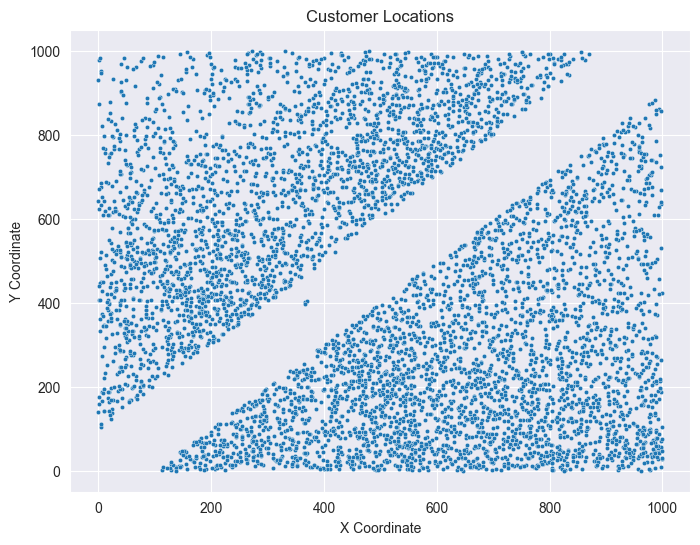

In [312]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Customer locations visualized
plt.figure(figsize=(8, 6))
sns.scatterplot(x=locations_df['x'], y=locations_df['y'],s=10)
plt.title("Customer Locations")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

### Step 2: Apply K-Means Clustering
We use k-means to identify three optimal depot locations. We assign each customer a depot label and convert the cluster centers back to the original scale. A scatter plot is then created, where customers are colored based on their assigned depot, and the depot locations are marked with red "X" markers.

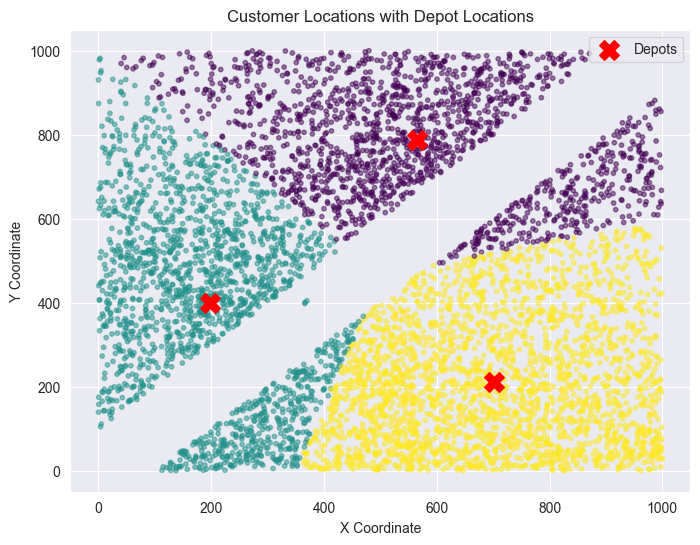

In [313]:
num_depots = 3

# Applied K-Means
kmeans = KMeans(n_clusters=num_depots, random_state=42, n_init=10)
locations_df['Depot'] = kmeans.fit_predict(X_scaled)

# Converted cluster centers to original scale
depot_locations = scaler.inverse_transform(kmeans.cluster_centers_)

# Scatter plot with cluster colors in original scale
plt.figure(figsize=(8, 6))
plt.scatter(locations_df['x'], locations_df['y'], c=locations_df['Depot'], cmap='viridis', alpha=0.5, s=10)
plt.scatter(depot_locations[:, 0], depot_locations[:, 1], c='red', marker='X', s=200, label='Depots')
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Customer Locations with Depot Locations")
plt.legend()
plt.show()

### Step 3: Attach Depot Information to Customers
Now, we add the depot information to the customer dataset.

In [314]:
# Add depot assignments to the original DataFrame
locations_df['closest_depot_x'] = locations_df['Depot'].map(lambda d: depot_locations[d, 0])
locations_df['closest_depot_y'] = locations_df['Depot'].map(lambda d: depot_locations[d, 1])

# Print first 10 rows
print(locations_df.head(10))

   clientid           x           y  Depot  closest_depot_x  closest_depot_y
0         1  622.771572  164.857623      2       701.313314       211.451823
1         2  416.357298  630.193634      0       564.250986       787.904875
2         3  292.735020  567.333231      1       196.957099       399.022426
3         4  737.211288  166.225676      2       701.313314       211.451823
4         5  540.475375  682.912298      0       564.250986       787.904875
5         6  535.469492  318.439661      2       701.313314       211.451823
6         7  640.380050  870.833221      0       564.250986       787.904875
7         8  235.772075  359.048203      1       196.957099       399.022426
8         9  481.896884  661.491838      0       564.250986       787.904875
9        10  730.032789  312.177817      2       701.313314       211.451823


### Step 4: Experiment with Different Number of Depots
We will now apply Agglomerative Hierarchical Clustering to group customer locations into different depot assignments. First, we will try different values for the number of depots (3, 5, and 10) to observe how clustering changes. Then, we will visualize the results by plotting the customer locations, coloring them based on their assigned depot, and marking depot locations with red "X" markers. Finally, we will analyze how the depot assignments change with varying cluster numbers. Increasing the number of depots reduces the distance between depots and customers but increases operational costs.

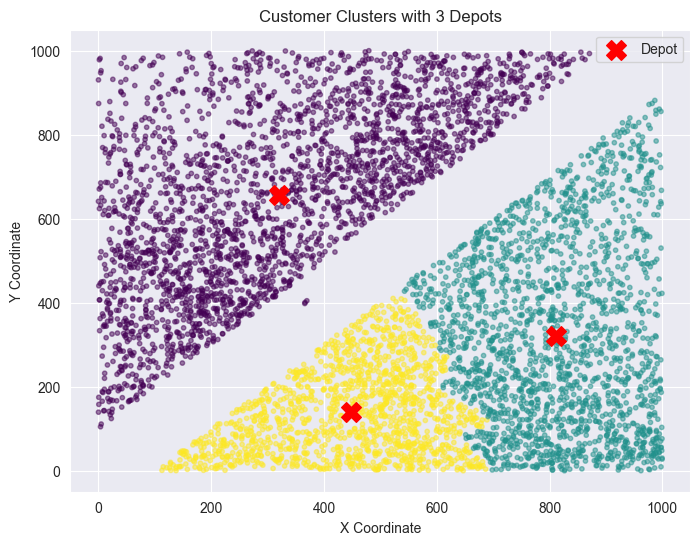

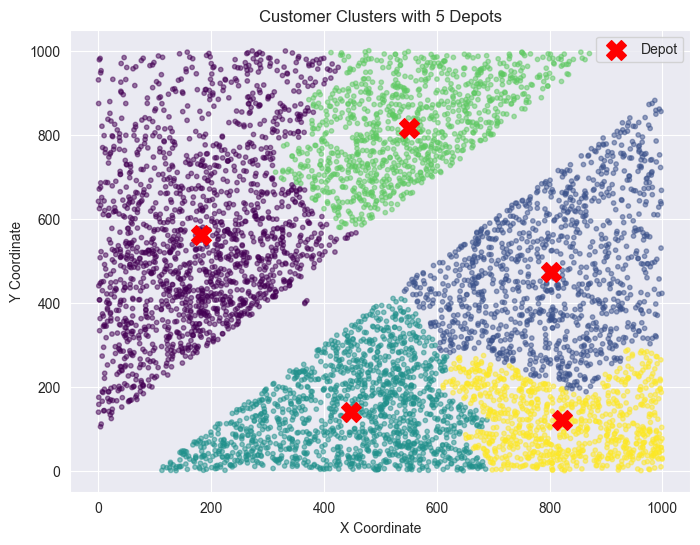

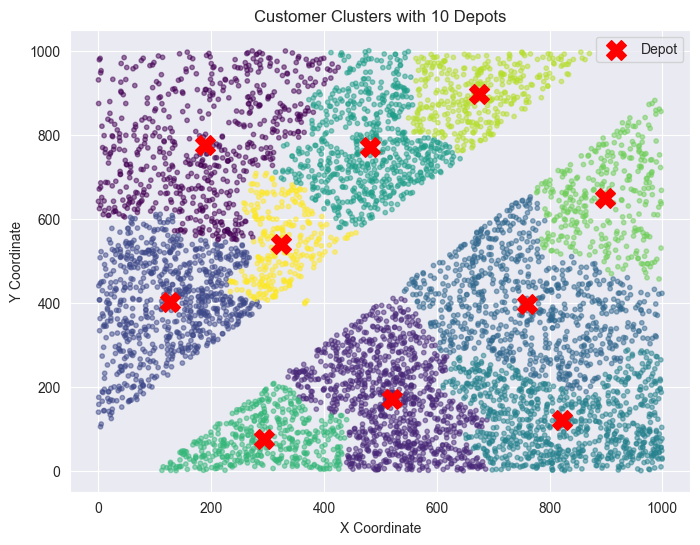

In [315]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

for k in [3, 5, 10]:
    # Apply Agglomerative Hierarchical Clustering to standardized data
    hierarchical = AgglomerativeClustering(n_clusters=k)
    locations_df['Depot'] = hierarchical.fit_predict(X_scaled)  # Use X_scaled here

    # Scatter plot with cluster colors in original scale
    plt.figure(figsize=(8, 6))
    plt.scatter(locations_df['x'], locations_df['y'], c=locations_df['Depot'], cmap='viridis', alpha=0.5, s=10)

    # Calculate and plot depot locations (mean of cluster points)
    for i in range(k):
        cluster_points = locations_df[locations_df['Depot'] == i][['x', 'y']]
        depot_x = cluster_points['x'].mean()
        depot_y = cluster_points['y'].mean()
        plt.scatter(depot_x, depot_y, c='red', marker='X', s=200, label='Depot' if i == 0 else "")  # Only label the first depot

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(f"Customer Clusters with {k} Depots")
    plt.legend()
    plt.show()


### Step 5: Compare with Hierarchical Clustering
This code implements Agglomerative Hierarchical Clustering to identify depot locations. It iterates over different values of k (3, 5, and 10) to perform clustering, measuring the execution time for each clustering operation. It prints the time taken for each clustering operation, providing insight into the computation efficiency for varying numbers of depots.

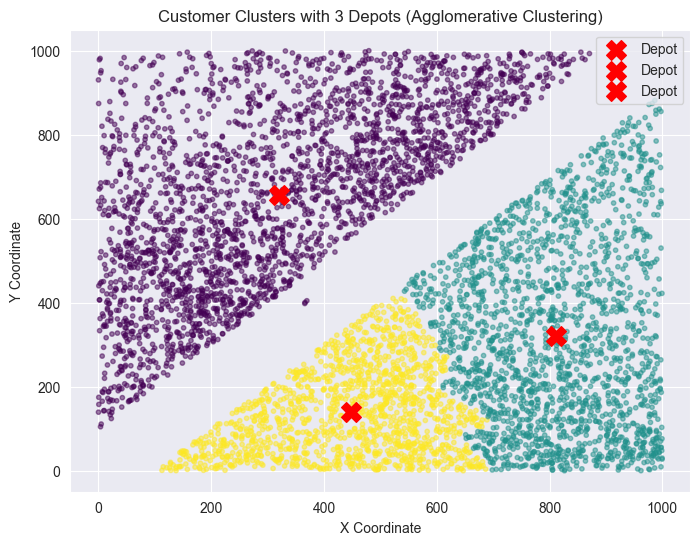

Agglomerative Clustering with 3 depots took 1.3988 seconds


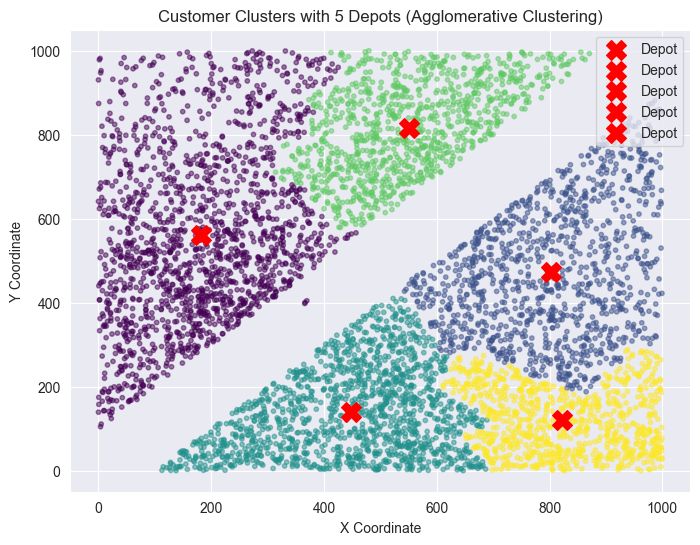

Agglomerative Clustering with 5 depots took 1.0696 seconds


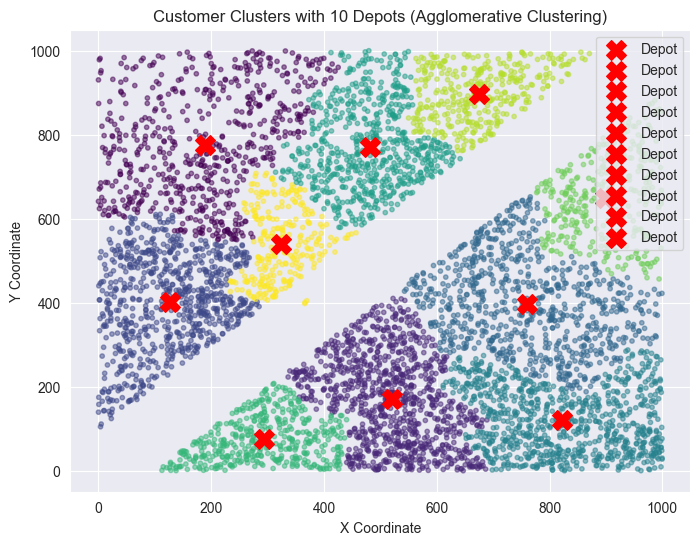

Agglomerative Clustering with 10 depots took 1.0483 seconds


In [316]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.cluster import AgglomerativeClustering


for k in [3, 5, 10]:
    start_time = time.time()  # Start timer

    # Apply Agglomerative Hierarchical Clustering
    hierarchical = AgglomerativeClustering(n_clusters=k)
    locations_df['Depot'] = hierarchical.fit_predict(X_scaled)

    # Compute depot locations as the mean of cluster points
    depot_locations = np.array([
        locations_df[locations_df['Depot'] == cluster][['x', 'y']].mean().values
        for cluster in range(k)
    ])

    # Scatter plot with cluster colors in original scale
    plt.figure(figsize=(8, 6))
    plt.scatter(locations_df['x'], locations_df['y'], c=locations_df['Depot'], cmap='viridis', alpha=0.5, s=10)

    # Plot depot locations with correct labels
    for i, (depot_x, depot_y) in enumerate(depot_locations):
        plt.scatter(depot_x, depot_y, c='red', marker='X', s=200, label='Depot')

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(f"Customer Clusters with {k} Depots (Agglomerative Clustering)")
    plt.legend()
    plt.show()

    print(f"Agglomerative Clustering with {k} depots took {time.time() - start_time:.4f} seconds")


#### Association Rule Mining
Association rule mining is a technique used to find patterns or relationships in a given dataset, especially to recognize which products are frequently bought together.

In this example, we are using the Apriori algorithm to identify these patterns. In this assingment Apriori helps us find the most frequent combinations of products, meaning what sets of items are often bought together.

In the code example, we are using a 5% support threshold. This means that if a set of products appears together in more than 5% of the transactions, we create a rule for this product set or pair.

##### Structure of the Rule:
The rule is created using two classifications:

- Antecedent: The condition (e.g., "Product A was bought").
- Consequent: The result (e.g., "Product B was bought").

When creating this rule, we use the confidence metric. Confidence measures the likelihood that Product B will be bought if Product A is already in the cart. The minimum confidence threshold is set to 60%. This means that if the purchase of Product A leads to the purchase of Product B more than 60% of the time, we can assume there’s a meaningful association.

Finally, we sort the rules based on lift. Lift measures the strength of the association between the items compared to what would be expected by random chance. A lift greater than 1 indicates that the two items are more likely to be bought together deliberately, rather than by chance.

##### Rule Metrics:
- Support: The frequency of the itemset appearing in the dataset (i.e., how often this set of items is bought together).
- Confidence: The probability that the consequent item (Product B) is bought when the antecedent item (Product A) is in the cart.
- Lift: The ratio of the observed frequency of the itemset appearing together to the frequency expected if the items were independent of each other. A lift > 1 indicates a strong association.


In [317]:
# Find frequently bought product combinations
frequent_itemsets = apriori(Y, min_support=0.05, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Sort by lift (stronger relationships first)
rules = rules.sort_values(by="lift", ascending=False)

# Display first few rules as a table
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

,antecedents,consequents,support,confidence,lift
1,( Prod15),( Prod9),0.11145,0.938131,4.725388
2,( Prod20),( Prod19),0.13476,0.910664,4.415125
3,( Prod19),( Prod20),0.13476,0.653350,4.415125
0,( Prod5),( Prod12),0.06683,0.638971,4.000822


### Evaluation


### Deployment